## 목적
- 새로운 모델 train 및 predict를 위한 전체 pipeline 정리

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

from sm_utils import make_train_data

from multiprocessing import Pool
from functools import partial
import operator

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

## train

## make input/label data
- 학습 대상: 요금제 일반 변경을 한 회선(기변 제외)
- Lable
    - Y: upsell
    - N: downsell
- Feature: user_profile_pivot 전체
- 기간
    - label: 201907 ~ 201909 
    - input: 201906 ~ 201908 

In [3]:
make_train_sql = """
drop table dumbo.dominic_new_upsell_train_data;
create table dumbo.dominic_new_upsell_train_data as 
select 
    b.*
,   a.bf_prod_id as label_bf_prod_id
,   a.af_prod_id as label_af_prod_id
,   a.upsell as label_upsell
,   a.diff as label_diff
,   a.eqp_chg_yn as label_eqp_chg_yn
,   a.af_channel as label_af_channel
,   a.ym as a_ym
,   b.ym as b_ym
from comm.user_label_matrix_for_fee_no_equip_temp a
join comm.user_profile_pivot_monthly b
on a.svc_mgmt_num = b.svc_mgmt_num 
and b.ym = date_format(add_months(from_unixtime(unix_timestamp(a.ym,'yyyyMM'),'yyyy-MM-dd'),-1), 'yyyyMM')
where a.ym between '201907' and '201909'
and a.age between 19 and 70 
;
"""

## load data

In [4]:
sql = """
select *
from dumbo.dominic_new_upsell_train_data
"""

In [5]:
df = load_from_hive(hive_connection('dmig'), sql)

2019-11-03 06:57:05,788 - YE_HIVE - INFO - ...tmp_db name = tmp_20191103_06_57_05_8103d2065cd7de890050328c810f1931b8448146
2019-11-03 06:57:05,790 - YE_HIVE - INFO - Start creating table
2019-11-03 06:57:05,791 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191103_06_57_05_8103d2065cd7de890050328c810f1931b8448146
2019-11-03 06:57:05,843 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191103_06_57_05_8103d2065cd7de890050328c810f1931b8448146' is done
2019-11-03 06:59:57,151 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191103_06_57_05_8103d2065cd7de890050328c810f1931b8448146 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select *
from dumbo.dominic_new_upsell_train_data
' is done
2019-11-03 06:59:57,418 - YE_HIVE - INFO - Elapsed Time = 171.63
2019-11-03 06:59:57,419 - YE_HIVE - 

In [6]:
df.shape, df.ym.value_counts()

((1833173, 434), 201907    663451
 201906    649082
 201908    520640
 Name: ym, dtype: int64)

## preprocess

In [7]:
# null check
col_null_sum = df.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  nugu_app_use_days              1312533
nugu_btv_rgst_yn               1312533
nugu_btv_use_days              1312533
nugu_use_days                  1312533
family_moa_data_usage_in_gb    1312533
family_sharable_fee_prod_yn    1833173
nugu_user_yn                   1312533
nugu_dvc_rgst_yn               1312533
family_moa_share_data_in_gb    1312533
nugu_app_rgst_yn               1312533
main_channel_eqp_buy           1312533
nugu_dvc_use_days              1312533
dtype: int64


In [8]:
df.drop(list(col_null_sum[col_null_sum>0].index), axis=1, inplace=True)

In [9]:
# 큰 의미 없는 변수 제거
filter_cols = [c for c in df.columns if 'filter_' in c]
zero_drop_list = ['tw_visit_days_fee_t_small', 'app_use_cnt_vr', 'tw_visit_days_vas_internet', 'tw_visit_days_vas_number_plus', 
                  'tw_visit_days_fee_senior_12g', 'tw_visit_days_vas_call_keeper', 'tw_visit_days_fee_t_large',
                  'tw_visit_days_wire_prod_list', 'mbr_discount_amt_theme_park', 'tw_visit_days_unbill', 'mbr_discount_cnt_coffee',
                  'tw_visit_days_vas_internet_family_comb', 'tw_visit_days_fee_t_infinity', 'tw_visit_days_vas_pooq', 
                  'tw_visit_days_fee_0_large', 'dsat_cnsl_cnt_bf_m2', 'mbr_discount_amt_sports', 
                  'mbr_discount_amt_beauty_and_fashion', 'tw_visit_days_fee_senior_save', 'mbr_discount_amt_chocolate', 
                  'tw_visit_days_tfamilymoa', 'mbr_discount_cnt_sports', 'tw_visit_days_vas_terminate', 'tw_visit_days_fee_t_ansim_4g',
                  'tw_visit_days_vas_my_smartcall', 'tw_visit_days_fee_t_save', 'tw_visit_days_fee_t_max',
                  'tw_visit_days_vas_call_available', 'mbr_discount_cnt_chocolate', 'tw_visit_days_fee_t_ansim_25g', 
                  'tw_visit_days_suspend', 'tw_visit_days_roaming_list', 'mbr_discount_cnt_jeju', 'tw_visit_days_vas_coloring', 
                  'mbr_discount_cnt_travel', 'app_use_traffic_shopping_parcel', 'tw_visit_days_fee_senior_with_t', 
                  'tw_visit_days_fee_t_family', 'mbr_discount_amt_travel', 'tw_visit_days_fee_0_small', 'tw_visit_days_fee_t_special',
                  'tw_visit_days_vas_calling_plus', 'dsat_cnsl_cnt_bf_m0', 'mbr_discount_amt_emart', 'mbr_discount_amt_transportation',
                  'mbr_discount_cnt_theme_park', 'mbr_discount_amt_coffee', 'tw_visit_days_fee_senior_22g', 'tw_visit_days_event', 
                  'tw_visit_days_vas_flo', 'tw_visit_days_fee_t_medium', 'mbr_discount_cnt_education', 'app_use_traffic_vr', 
                  'mbr_discount_amt_education', 'tw_visit_days_child_fee', 'tw_visit_days_fee_0_medium', 'tw_visit_days_vas_call_routing', 
                  'mbr_discount_cnt_transportation', 'mbr_discount_cnt_beauty_and_fashion', 'mbr_discount_amt_jeju', 'dsat_cnsl_cnt_bf_m1', 
                  'tw_visit_days_agentsearch', 'tw_visit_days_emailconsult', 'mbr_discount_cnt_music', 'mbr_discount_cnt_emart', 
                  'tw_visit_days_fee_t_regular', 'tw_visit_days_vas_perfect_call', 'mbr_discount_amt_music', 'sms_snd_cnt_sports', 
                  'sms_snd_cnt_student', 'sms_rcv_cnt_security', 'sms_snd_cnt_pet', 'voc_snd_cnt_security', 'voc_snd_cnt_wedding', 
                  'sms_snd_cnt_tax', 'voc_rcv_cnt_pet', 'sms_snd_cnt_restaurant', 'sms_rcv_cnt_home_move', 'sms_rcv_cnt_wedding', 
                  'voc_rcv_cnt_wedding', 'sms_snd_cnt_home_move', 'sms_snd_cnt_beauty', 'voc_rcv_cnt_security', 'sms_snd_cnt_security', 
                  'voc_rcv_cnt_interior', 'sms_snd_cnt_interior', 'sms_rcv_cnt_pet', 'sms_snd_cnt_wedding', 'sms_rcv_cnt_interior', 
                  'sms_snd_cnt_travel', 'voc_rcv_cnt_tax', 'sms_snd_cnt_baby', 'scrb_sta_dt', 'cust_birth_dt', 'cncl_aply_bf_equip_chg_dt', 
                  'svc_scrb_dt', 'fee_chg_dt', 'cncl_aply_last_equip_chg_dt'] + filter_cols

In [10]:
df.drop(zero_drop_list, axis=1, inplace=True)
df.shape

(1833173, 300)

## EDA

#### 기기 변경 vs 일반 변경
- 전체 요금제 변경 중 기변 건이 41%
- 기변일 경우 upsell 비율: 85.76
- 일반 변경의 경우 upsell qldbf: 56.11

In [18]:
df.shape

(1833173, 300)

In [27]:
df.label_eqp_chg_yn.value_counts()

N    1073326
Y     759847
Name: label_eqp_chg_yn, dtype: int64

In [15]:
df.label_eqp_chg_yn.value_counts()/df.shape[0]

N    0.585502
Y    0.414498
Name: label_eqp_chg_yn, dtype: float64

In [17]:
for y in ['Y', 'N']:
    df_tmp = df[df['label_eqp_chg_yn']==y]
    print('true/false: ', y)
    display(df_tmp.label_upsell.value_counts()/df_tmp.shape[0])

true/false:  Y


Y    0.857638
N    0.142362
Name: label_upsell, dtype: float64

true/false:  N


Y    0.561177
N    0.438823
Name: label_upsell, dtype: float64

In [25]:
sns.set(rc={'figure.figsize': (20,5)})
sns.distplot(df[df['label_eqp_chg_yn']=='Y'].bas_fee_amt, norm_hist=True, label='device', bins=np.arange(0, 100000, 2000))
sns.distplot(df[df['label_eqp_chg_yn']=='N'].bas_fee_amt, norm_hist=True, label='normal', bins=np.arange(0, 100000, 2000))
plt.legend()

In [24]:
df[df['label_eqp_chg_yn']=='Y'].bas_fee_amt.mean(), df[df['label_eqp_chg_yn']=='N'].bas_fee_amt.mean()

(55142.55819263615, 48102.64045592858)

In [12]:
print('기변 포함 upsell ratio: ', df.label_upsell.value_counts()/df.shape[0])

# 기변 내역 제거
df = df[df['label_eqp_chg_yn']=='N']

print('기변 내역 제거 후 upsell ratio: ', df.label_upsell.value_counts()/df.shape[0])

기변 포함 upsell ratio:  Y    0.68406
N    0.31594
Name: label_upsell, dtype: float64
기변 내역 제거 후 upsell ratio:  Y    0.561177
N    0.438823
Name: label_upsell, dtype: float64


#### 채널 별 특성

In [31]:
df.groupby(['label_eqp_chg_yn', 'label_af_channel'])['bas_fee_amt'].mean()

label_eqp_chg_yn  label_af_channel
N                 N/A                 46999.654051
                  T월드                 52599.099804
                  고객센터                47215.030525
                  오프라인                43696.262665
Y                 N/A                 67963.333333
                  T월드                 55068.920061
                  고객센터                52432.513922
                  오프라인                55154.084936
Name: bas_fee_amt, dtype: float64

In [29]:
df.label_af_channel.value_counts()

오프라인    1000071
고객센터     454275
T월드      373751
N/A        5076
Name: label_af_channel, dtype: int64

In [13]:
# 채널 별 upsell ratio
for c in ['T월드', '고객센터', '오프라인']:
    df_tmp = df[df['label_af_channel']==c]
    print('='*50)
    print('channel: ', c)
    display(df_tmp.label_upsell.value_counts()/df_tmp.shape[0])

channel:  T월드


Y    0.546597
N    0.453403
Name: label_upsell, dtype: float64

channel:  고객센터


Y    0.721574
N    0.278426
Name: label_upsell, dtype: float64

channel:  오프라인


N    0.694621
Y    0.305379
Name: label_upsell, dtype: float64

In [35]:
df_trn['label_af_channel'].value_counts()/df_trn.shape[0]

고객센터    0.450191
T월드     0.315921
오프라인    0.233889
Name: label_af_channel, dtype: float64

In [36]:
df_val['label_af_channel'].value_counts()/df_val.shape[0]

고객센터    0.413045
T월드     0.316617
오프라인    0.270338
Name: label_af_channel, dtype: float64

In [37]:
df_tst['label_af_channel'].value_counts()/df_tst.shape[0]

고객센터    0.402814
T월드     0.356495
오프라인    0.240691
Name: label_af_channel, dtype: float64

## Label encoding

In [14]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

cat_cols = list(df.select_dtypes(include=['object']).columns)
cat_cols

['svc_mgmt_num',
 'sex_cd',
 'eqp_mdl_cd',
 'additional_svc_oksusu_scrb_type',
 'fee_prod_id',
 'data_gift_recv_yn_bf_m2',
 'copn_data_u1_yn_bf_m0',
 'channel',
 'rmk_omd_yn',
 'op_sale_chnl_cl_cd',
 'smartwatch_yn',
 'additional_svc_allcare_scrb_type',
 'prod_nm',
 'additional_svc_ansim_option_scrb_type',
 'nh00000059_yn',
 'data_gift_send_yn_bf_m0',
 'job_cd',
 'copn_data_u1_yn_bf_m1',
 'childwatch_yn',
 'family_marriage_yn',
 'nm_cust_num',
 'mbr_card_gr_cd',
 'tablet_yn',
 'additional_svc_flo_scrb_type',
 'na00002040_yn',
 'svc_gr_cd',
 'family_yn',
 'nh00000037_yn',
 'sec_dev_yn',
 'mng_nice_cb_scr',
 'additional_svc_melon_scrb_type',
 'nh00000084_yn',
 'family_rep_yn',
 'family_child_yn',
 't_agr_t_eqpal_scrb_yn',
 'nh00000133_yn',
 'mng_nice_cb_grd',
 'additional_svc_bugs_scrb_type',
 'data_gift_recv_yn_bf_m0',
 'nh00000114_yn',
 'scrb_sale_chnl_cl_cd',
 'data_gift_send_yn_bf_m1',
 'nh00000103_yn',
 'tmap_freq_dest_residence',
 'nh00000039_yn',
 'na00004430_yn',
 'family_wire_comb_yn',
 'additional_svc_pooq_scrb_type',
 'family_small_yn',
 'data_gift_send_yn_bf_m2',
 'data_gift_recv_yn_bf_m1',
 't_agr_t_eqpal_scrb_ym',
 'copn_data_u1_yn_bf_m2',
 'ym',
 'label_bf_prod_id',
 'label_af_prod_id',
 'label_upsell',
 'label_eqp_chg_yn',
 'label_af_channel',
 'a_ym',
 'b_ym']

In [15]:
label_cols = [c for c in cat_cols if 'label_' in c]
label_cols

['label_bf_prod_id',
 'label_af_prod_id',
 'label_upsell',
 'label_eqp_chg_yn',
 'label_af_channel']

In [16]:
cat_cols.remove('svc_mgmt_num')
cat_cols.remove('label_bf_prod_id')
cat_cols.remove('label_af_prod_id')
cat_cols.remove('label_eqp_chg_yn')
cat_cols.remove('label_af_channel')
cat_cols.remove('prod_nm') # debugging위해
cat_cols.remove('fee_prod_id') # bas_fee_amt와 중복
cat_cols.remove('ym')
cat_cols.remove('a_ym')
cat_cols.remove('b_ym')

In [17]:
# label encodinng
d = defaultdict(LabelEncoder)
df[cat_cols] = df[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

d.keys()

dict_keys(['sex_cd', 'eqp_mdl_cd', 'additional_svc_oksusu_scrb_type', 'data_gift_recv_yn_bf_m2', 'copn_data_u1_yn_bf_m0', 'channel', 'rmk_omd_yn', 'op_sale_chnl_cl_cd', 'smartwatch_yn', 'additional_svc_allcare_scrb_type', 'additional_svc_ansim_option_scrb_type', 'nh00000059_yn', 'data_gift_send_yn_bf_m0', 'job_cd', 'copn_data_u1_yn_bf_m1', 'childwatch_yn', 'family_marriage_yn', 'nm_cust_num', 'mbr_card_gr_cd', 'tablet_yn', 'additional_svc_flo_scrb_type', 'na00002040_yn', 'svc_gr_cd', 'family_yn', 'nh00000037_yn', 'sec_dev_yn', 'mng_nice_cb_scr', 'additional_svc_melon_scrb_type', 'nh00000084_yn', 'family_rep_yn', 'family_child_yn', 't_agr_t_eqpal_scrb_yn', 'nh00000133_yn', 'mng_nice_cb_grd', 'additional_svc_bugs_scrb_type', 'data_gift_recv_yn_bf_m0', 'nh00000114_yn', 'scrb_sale_chnl_cl_cd', 'data_gift_send_yn_bf_m1', 'nh00000103_yn', 'tmap_freq_dest_residence', 'nh00000039_yn', 'na00004430_yn', 'family_wire_comb_yn', 'additional_svc_pooq_scrb_type', 'family_small_yn', 'data_gift_send_yn

In [18]:
## save label encoder
with open(os.path.join(DATA_PATH, 'new_upsell_le_dict.pkl'), 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
## save train data
df.to_pickle(os.path.join(DATA_PATH, 'new_upsell_1101.pkl'))

## modeling

In [69]:
from sklearn.model_selection import train_test_split
from sm_utils import sampling, evaluate, save_model, load_model

In [20]:
# channel
df = df[df.label_af_channel!='N/A']

In [22]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [23]:
df_trn = df[df['b_ym']=='201906']
df_val = df[df['b_ym']=='201907']
df_tst = df[df['b_ym']=='201908']

df_trn.shape, df_val.shape, df_tst.shape

((371929, 300), (374642, 300), (321682, 300))

In [25]:
del df
import gc
gc.collect()

13553

In [26]:
label_cols = [c for c in df_trn.columns if 'label_' in c]
del_cols = ['svc_mgmt_num', 'ym', 'a_ym', 'b_ym', 'nm_cust_num', 'fee_prod_id', 'prod_nm']
del_cols += label_cols
feature_cols = [c for c in df_trn.columns if c not in del_cols]

In [39]:
target = 'label_upsell'

In [67]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'num_threads': 50,
}

## 채널 별 모델링

channel:  고객센터
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.912393	valid_1's auc: 0.909951
[100]	training's auc: 0.923262	valid_1's auc: 0.91976
[150]	training's auc: 0.928661	valid_1's auc: 0.924643
[200]	training's auc: 0.932248	valid_1's auc: 0.927744
[250]	training's auc: 0.934862	valid_1's auc: 0.92943
[300]	training's auc: 0.937112	valid_1's auc: 0.930636
[350]	training's auc: 0.938901	valid_1's auc: 0.931109
[400]	training's auc: 0.940563	valid_1's auc: 0.931643
[450]	training's auc: 0.942206	valid_1's auc: 0.932045
[500]	training's auc: 0.94363	valid_1's auc: 0.932296
[550]	training's auc: 0.94494	valid_1's auc: 0.93251
[600]	training's auc: 0.946274	valid_1's auc: 0.932798
[650]	training's auc: 0.947486	valid_1's auc: 0.932931
[700]	training's auc: 0.948694	valid_1's auc: 0.933076
[750]	training's auc: 0.949881	valid_1's auc: 0.933278
[800]	training's auc: 0.950969	valid_1's auc: 0.933382
[850]	training's auc: 0.951956	valid_1's auc: 0.

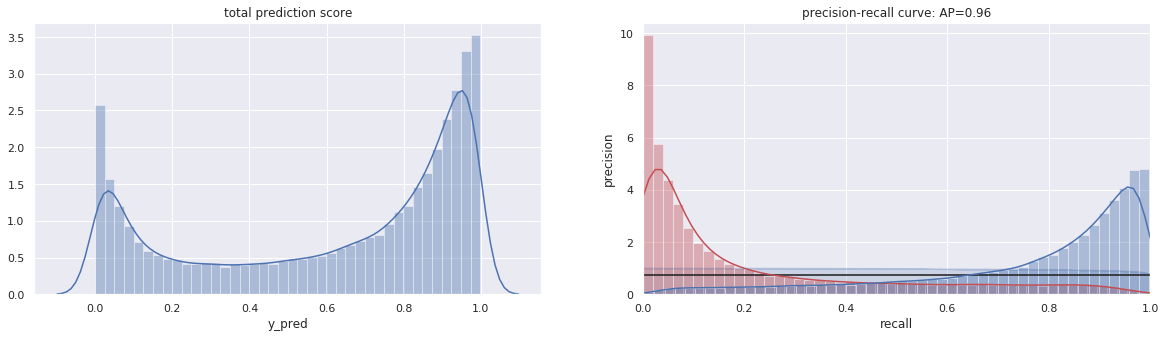

channel:  T월드
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.870111	valid_1's auc: 0.87644
[100]	training's auc: 0.8867	valid_1's auc: 0.890685
[150]	training's auc: 0.89538	valid_1's auc: 0.897747
[200]	training's auc: 0.900969	valid_1's auc: 0.901989
[250]	training's auc: 0.904934	valid_1's auc: 0.90466
[300]	training's auc: 0.90812	valid_1's auc: 0.906562
[350]	training's auc: 0.910859	valid_1's auc: 0.907976
[400]	training's auc: 0.913263	valid_1's auc: 0.908838
[450]	training's auc: 0.915418	valid_1's auc: 0.909469
[500]	training's auc: 0.917391	valid_1's auc: 0.909959
[550]	training's auc: 0.919243	valid_1's auc: 0.910257
[600]	training's auc: 0.921089	valid_1's auc: 0.910693
[650]	training's auc: 0.922863	valid_1's auc: 0.910955
[700]	training's auc: 0.924589	valid_1's auc: 0.911229
[750]	training's auc: 0.926206	valid_1's auc: 0.911356
[800]	training's auc: 0.927765	valid_1's auc: 0.911507
[850]	training's auc: 0.929299	valid_1's auc: 0.91

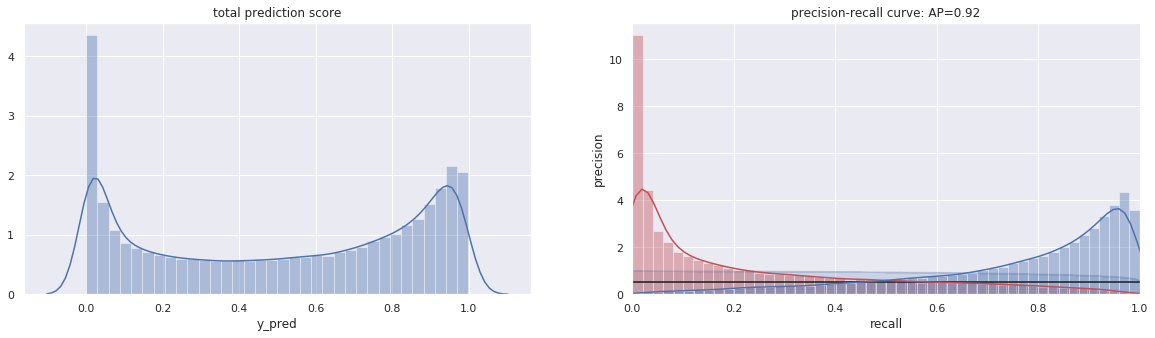

channel:  오프라인
Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.927025	valid_1's auc: 0.916721
[100]	training's auc: 0.937173	valid_1's auc: 0.926353
[150]	training's auc: 0.942867	valid_1's auc: 0.930886
[200]	training's auc: 0.946548	valid_1's auc: 0.933534
[250]	training's auc: 0.94935	valid_1's auc: 0.934964
[300]	training's auc: 0.951471	valid_1's auc: 0.935621
[350]	training's auc: 0.95346	valid_1's auc: 0.93611
[400]	training's auc: 0.955318	valid_1's auc: 0.936534
[450]	training's auc: 0.956971	valid_1's auc: 0.936692
[500]	training's auc: 0.958526	valid_1's auc: 0.936861
[550]	training's auc: 0.960008	valid_1's auc: 0.937088
[600]	training's auc: 0.961447	valid_1's auc: 0.937242
[650]	training's auc: 0.962779	valid_1's auc: 0.937342
[700]	training's auc: 0.964085	valid_1's auc: 0.937407
[750]	training's auc: 0.965384	valid_1's auc: 0.937508
[800]	training's auc: 0.966578	valid_1's auc: 0.937608
[850]	training's auc: 0.967678	valid_1's auc: 

In [70]:
clf_dict = {}
for c in ['고객센터', 'T월드', '오프라인']:
    print('='*50)
    print('channel: ', c)
    
    df_trn_tmp = df_trn[df_trn['label_af_channel']==c]
    df_val_tmp = df_val[df_val['label_af_channel']==c]
    df_tst_tmp = df_tst[df_tst['label_af_channel']==c]
    
    # train
    lgb_trn = lgb.Dataset(df_trn_tmp[feature_cols], df_trn_tmp[target], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val_tmp[feature_cols], df_val_tmp[target], feature_name=feature_cols)
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])
    
    # evaluate
    eval_result = evaluate(df_tst_tmp[feature_cols], df_tst_tmp[target].values, clf, clf_name='lgb')
    
    # save
    clf_dict[c] = clf

## 한 번에 모델링

In [71]:
# train
lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target], feature_name=feature_cols)
lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target], feature_name=feature_cols)
clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

# evaluate
eval_result = evaluate(df_tst[feature_cols], df_tst[target].values, clf, clf_name='lgb')

# save
clf_dict['total'] = clf

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.898428	valid_1's auc: 0.900678
[100]	training's auc: 0.910391	valid_1's auc: 0.911829
[150]	training's auc: 0.916445	valid_1's auc: 0.917131
[200]	training's auc: 0.920208	valid_1's auc: 0.920329
[250]	training's auc: 0.923142	valid_1's auc: 0.922722
[300]	training's auc: 0.925153	valid_1's auc: 0.924347
[350]	training's auc: 0.926802	valid_1's auc: 0.925552
[400]	training's auc: 0.928226	valid_1's auc: 0.926565
[450]	training's auc: 0.92939	valid_1's auc: 0.927343
[500]	training's auc: 0.930411	valid_1's auc: 0.927946
[550]	training's auc: 0.93125	valid_1's auc: 0.928275
[600]	training's auc: 0.932065	valid_1's auc: 0.92865
[650]	training's auc: 0.932818	valid_1's auc: 0.928885
[700]	training's auc: 0.933564	valid_1's auc: 0.929198
[750]	training's auc: 0.934326	valid_1's auc: 0.929531
[800]	training's auc: 0.934946	valid_1's auc: 0.929692
[850]	training's auc: 0.935549	valid_1's auc: 0.92983
[900]	t

In [43]:
clf_dict

{'고객센터': <lightgbm.basic.Booster at 0x7fb148886860>,
 'T월드': <lightgbm.basic.Booster at 0x7fb1488eaa58>,
 '오프라인': <lightgbm.basic.Booster at 0x7fb1488d0eb8>,
 'total': <lightgbm.basic.Booster at 0x7fb1488cd518>}

## evaluate
- 채널별 모델이 더 나은 성능을 보일까?
- 0.5 이상 & 상위 600만

In [44]:
df_tst.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   1010502700       1  57.0     15283.0000             0.0   
2   1013331315       2  35.0     26585.3333             0.0   
3   1014072704       1  44.0     53454.6667             0.0   
4   1027102500       1  45.0     43471.0000             0.0   
8   1040096309       1  56.0     33173.0000             0.0   

   last_eqp_buy_duration  location_weekday_visit_dong  \
0                   92.0                         79.0   
2                   -6.0                         11.0   
3                    0.0                          6.0   
4                  108.0                         41.0   
8                   30.0                         24.0   

   mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
0                                 0.0                36.5932   
2                                 0.0                 0.0000   
3                                 0.0                 0.0000   
4                                 0.0                 0.0000   
8                                 0.0                 0.0000   

   app_use_traffic_driver  ...  app_use_traffic_flo      ym  label_bf_prod_id  \
0                0.000000  ...             3.829741  201908        NA00006535   
2                0.000000  ...             0.000000  201908        NA00004775   
3                6.957456  ...             0.000000  201908        NA00005293   
4                0.000000  ...             0.000000  201908        NA00006537   
8                0.000000  ...             0.000000  201908        NA00006538   

   label_af_prod_id  label_upsell  label_diff  label_eqp_chg_yn  \
0        NA00006536             1        7000                 N   
2        NA00006537             1        3110                 N   
3        NA00006538             0       -9000                 N   
4        NA00005483             0      -25825                 N   
8        NA00006535             0      -36000                 N   

   label_af_channel    a_ym    b_ym  
0               T월드  201909  201908  
2              고객센터  201909  201908  
3              오프라인  201909  201908  
4               T월드  201909  201908  
8              고객센터  201909  201908  

[5 rows x 300 columns]

In [72]:
for channel, clf in clf_dict.items():
    print('channel: ', channel)
    df_tst[channel] = clf.predict(df_tst[feature_cols], num_threads=40)
    df_tst['{}_pred'.format(channel)] = df_tst[channel]>0.5
    df_tst['{}_pred'.format(channel)] = df_tst['{}_pred'.format(channel)].astype(int)

channel:  고객센터
channel:  T월드
channel:  오프라인
channel:  total


In [73]:
df_tst.shape

(321682, 308)

In [74]:
df_tst.head()

svc_mgmt_num  sex_cd   age  real_avg_arpu  roaming_cnt_m3  \
0   1010502700       1  57.0     15283.0000             0.0   
2   1013331315       2  35.0     26585.3333             0.0   
3   1014072704       1  44.0     53454.6667             0.0   
4   1027102500       1  45.0     43471.0000             0.0   
8   1040096309       1  56.0     33173.0000             0.0   

   last_eqp_buy_duration  location_weekday_visit_dong  \
0                   92.0                         79.0   
2                   -6.0                         11.0   
3                    0.0                          6.0   
4                  108.0                         41.0   
8                   30.0                         24.0   

   mbr_discount_cnt_convenience_store  app_use_traffic_movie  \
0                                 0.0                36.5932   
2                                 0.0                 0.0000   
3                                 0.0                 0.0000   
4                                 0.0                 0.0000   
8                                 0.0                 0.0000   

   app_use_traffic_driver  ...    a_ym    b_ym      고객센터       T월드      오프라인  \
0                0.000000  ...  201909  201908  0.381141  0.483243  0.118211   
2                0.000000  ...  201909  201908  0.136862  0.250753  0.372865   
3                6.957456  ...  201909  201908  0.132305  0.099137  0.359919   
4                0.000000  ...  201909  201908  0.628242  0.627733  0.775144   
8                0.000000  ...  201909  201908  0.160310  0.037414  0.042774   

      total  고객센터_pred  T월드_pred 오프라인_pred  total_pred  
0  0.265463          0         0         0           0  
2  0.221675          0         0         0           0  
3  0.192993          0         0         0           0  
4  0.766032          1         1         1           1  
8  0.116293          0         0         0           0  

[5 rows x 308 columns]

In [75]:
df_tst.label_af_channel.value_counts()

고객센터    129578
T월드     114678
오프라인     77426
Name: label_af_channel, dtype: int64

In [76]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

In [77]:
def evaluate(y_true, y_pred_class, y_pred):
    df_metrics = pd.DataFrame({'acc': accuracy_score(y_true, y_pred_class),
                               'recall': recall_score(y_true, y_pred_class),
                               'precision': precision_score(y_true, y_pred_class),
                               'f1_score': f1_score(y_true, y_pred_class),
                               'auc': roc_auc_score(y_true, y_pred)}, index=[0])
    display(df_metrics)

In [78]:
for c in ['고객센터', 'T월드', '오프라인']:
    print('='*50)
    print('channel: ', c)
    
    df_tmp = df_tst[df_tst['label_af_channel']==c]
    print('shape: ', df_tmp.shape)
    
    
    for channel, clf in clf_dict.items():
        print('-'*20)
        print('trained channel: ', channel)
        
        y_true = 'label_upsell'
        y_pred_class = '{}_pred'.format(channel)
        y_pred = channel
        
        evaluate(df_tmp[y_true], df_tmp[y_pred_class], df_tmp[y_pred])

channel:  고객센터
shape:  (129578, 308)
--------------------
trained channel:  고객센터


acc    recall  precision  f1_score       auc
0  0.844271  0.848256   0.930648  0.887544  0.920024

--------------------
trained channel:  T월드


acc    recall  precision  f1_score       auc
0  0.816396  0.811111   0.926291  0.864883  0.900165

--------------------
trained channel:  오프라인


acc    recall  precision  f1_score       auc
0  0.816867  0.835952   0.904038  0.868663  0.886765

--------------------
trained channel:  total


acc    recall  precision  f1_score       auc
0  0.850854  0.862573   0.926487  0.893388  0.919683

channel:  T월드
shape:  (114678, 308)
--------------------
trained channel:  고객센터


acc    recall  precision  f1_score      auc
0  0.804514  0.828221   0.805541  0.816724  0.88425

--------------------
trained channel:  T월드


acc    recall  precision  f1_score      auc
0  0.83199  0.849793   0.833906  0.841774  0.91446

--------------------
trained channel:  오프라인


acc    recall  precision  f1_score       auc
0  0.795706  0.845366   0.783333  0.813168  0.879216

--------------------
trained channel:  total


acc    recall  precision  f1_score      auc
0  0.827709  0.857221    0.82263  0.839569  0.90892

channel:  오프라인
shape:  (77426, 308)
--------------------
trained channel:  고객센터


acc    recall  precision  f1_score       auc
0  0.833609  0.798662   0.702963  0.747763  0.895986

--------------------
trained channel:  T월드


acc    recall  precision  f1_score       auc
0  0.839369  0.822919   0.705764  0.759852  0.912416

--------------------
trained channel:  오프라인


acc    recall  precision  f1_score       auc
0  0.859195  0.864157   0.729693  0.791253  0.940277

--------------------
trained channel:  total


acc    recall  precision  f1_score       auc
0  0.858872  0.828984   0.743501  0.783919  0.933597

## overfitting

In [84]:
for c, clf in clf_dict.items():
    print('c: ', c)
    df_fea = pd.DataFrame({'feature': clf_dict[c].feature_name(),
                           'importance': clf_dict[c].feature_importance()})
    display(df_fea.sort_values('importance', ascending=False).head(20))

c:  고객센터


feature  importance
39                  bas_fee_amt        1105
77               fee_chg_period         549
236     bas_ofr_data_gb_qty_val         545
1                           age         423
132  bf_m6_data_usage_ratio_avg         386
273       t_agr_t_eqpal_scrb_ym         264
234                 voc_srv_cnt         258
152      real_data_use_gb_bf_m0         222
33              real_arpu_bf_m1         199
23         voc_snd_avg_duration         188
14                   eqp_mdl_cd         186
24               eqp_chg_period         174
37         voc_rcv_avg_duration         166
32                  eqp_out_prc         151
40       day_traffic_hour_ratio         149
180                 voc_snd_cnt         146
155             mng_nice_cb_scr         145
278             real_arpu_bf_m3         141
178                 sms_rcv_cnt         139
105            voc_rcv_miss_cnt         132

c:  T월드


feature  importance
39                  bas_fee_amt        1434
1                           age         540
77               fee_chg_period         539
236     bas_ofr_data_gb_qty_val         523
132  bf_m6_data_usage_ratio_avg         425
152      real_data_use_gb_bf_m0         328
234                 voc_srv_cnt         318
273       t_agr_t_eqpal_scrb_ym         296
32                  eqp_out_prc         290
14                   eqp_mdl_cd         288
184             svc_scrb_period         261
33              real_arpu_bf_m1         254
178                 sms_rcv_cnt         250
24               eqp_chg_period         247
40       day_traffic_hour_ratio         244
23         voc_snd_avg_duration         225
37         voc_rcv_avg_duration         224
155             mng_nice_cb_scr         219
148     app_use_traffic_twitter         215
278             real_arpu_bf_m3         213

c:  오프라인


feature  importance
39                  bas_fee_amt        1327
1                           age         593
236     bas_ofr_data_gb_qty_val         457
77               fee_chg_period         405
132  bf_m6_data_usage_ratio_avg         369
234                 voc_srv_cnt         347
24               eqp_chg_period         301
273       t_agr_t_eqpal_scrb_ym         282
155             mng_nice_cb_scr         248
14                   eqp_mdl_cd         243
40       day_traffic_hour_ratio         240
184             svc_scrb_period         232
37         voc_rcv_avg_duration         230
121        family_comb_duration         228
32                  eqp_out_prc         222
124                 sms_snd_cnt         222
23         voc_snd_avg_duration         214
172            night_traffic_mb         202
178                 sms_rcv_cnt         201
105            voc_rcv_miss_cnt         198

c:  total


feature  importance
39                  bas_fee_amt        2057
77               fee_chg_period         935
236     bas_ofr_data_gb_qty_val         892
1                           age         863
132  bf_m6_data_usage_ratio_avg         579
234                 voc_srv_cnt         415
152      real_data_use_gb_bf_m0         382
24               eqp_chg_period         334
40       day_traffic_hour_ratio         299
273       t_agr_t_eqpal_scrb_ym         297
33              real_arpu_bf_m1         281
32                  eqp_out_prc         271
184             svc_scrb_period         268
23         voc_snd_avg_duration         263
14                   eqp_mdl_cd         263
178                 sms_rcv_cnt         254
121        family_comb_duration         253
155             mng_nice_cb_scr         248
278             real_arpu_bf_m3         242
37         voc_rcv_avg_duration         230